# Neural-Translation-Seq2Seq: English-to-German Study
### *Encoder-Decoder Architectures for Large-Scale Neural Machine Translation*

**Abstract:** This study investigates the implementation of a Neural Machine Translation (NMT) system using a Sequence-to-Sequence (Seq2Seq) framework. Leveraging a bilingual corpus of **200,000 English-German sentence pairs**, we develop an Encoder-Decoder architecture based on **Long Short-Term Memory (LSTM)** units.

The research details a high-performance NLP pipeline optimized for scalability, featuring:

- **Transfer Learning:** Integration of pre-trained NNLM embeddings for semantic feature extraction.

- **Streaming Data Engineering:** A `tf.data.Dataset` pipeline with vectorized padding and prefetching for efficient GPU utilization.

- **Recursive Inference:** Application of a masked loss function and greedy decoding to handle variable-length sequences.

The results validate the model's ability to map complex latent semantic representations across languages, achieving stable convergence on a representative 10,000-sentence holdout set.

In [1]:
# 1. Imports (Standard Library)
import os, warnings, urllib3, logging, gdown, zipfile, io, re, \
       random, unicodedata, requests, math

# 2. Environment Setup for Logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'      # Silence TF C++ logs
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0'     # Silence XLA/Abseil logs
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' # Reduces extra oneDNN initialization logs

# 3. Warning Suppression
warnings.filterwarnings('ignore')
urllib3.disable_warnings()

# 4. TensorFlow Specific Setup
import tensorflow as tf

# Clear previous sessions to free VRAM
tf.keras.backend.clear_session()

# Set internal TF logger to Error only
tf.get_logger().setLevel('ERROR')

# 5. Additional Imports
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Layer, Input, Masking, LSTM,
                                     Embedding, Dense)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

from nltk.translate.bleu_score import corpus_bleu

E0000 00:00:1769794610.161490   62084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769794610.169031   62084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769794610.187512   62084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769794610.187563   62084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769794610.187564   62084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769794610.187566   62084 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# GPU Detection and Specification
# 1. Check if TensorFlow detects the GPU
device_name = tf.test.gpu_device_name()

if not device_name:
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, to to Runtime > Change runtime type and select "T4 GPU" for significantly faster NMT training.')
else:
    print(f'✅ Found GPU at: {device_name}')

    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

✅ Found GPU at: /device:GPU:0

Hardware Specifications:


I0000 00:00:1769794618.789106   62084 gpu_device.cc:2019] Created device /device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB


In [3]:
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


## **1. Data Engineering & Preprocessing Methodology**
The dataset consists of sentence pairs from the ManyThings.org German-English corpus. To ensure the model learns semantic relationships rather than noise, we implement the following preprocessing pipeline:

- **Text Normalization:** Converting strings to lowercase and utilizing `unicodedata` to standardize characters (removing accents/diacritics).

- **Punctuation Handling:** Inserting spaces around punctuation marks to ensure they are treated as individual tokens.

- **Recursive Bounds:** Appending `<start>` and `<end>` tokens to the German sequences, defining the causal boundaries for the Decoder.

- **Vectorized Tokenization:** Converting text into integer sequences and applying post-padding to ensure uniform tensor shapes for batch processing.

### **1.1 Dataset Source & Acquisition**
The model is trained on the **ManyThings.org English-German corpus**. To move beyond simple prototyping, this implementation utilizes a scaled dataset of **200,000 sentence pairs**. This dataset is specifically chosen for Sequence-to-Sequence (Seq2Seq) tasks due to its structural diversity and clean alignment.


In [4]:
# --- 1. Universal Environment Setup ---
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    PROJECT_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NMT/'
    if not os.path.exists(PROJECT_PATH):
        os.makedirs(PROJECT_PATH)
    os.chdir(PROJECT_PATH)
    BASE_DIR = './'
    print(f"✅ Environment: Google Colab. Directory: {os.getcwd()}")
except ImportError:
    BASE_DIR = '../'
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: /home/ml/projects/nmt-seq2seq-translation/notebooks


In [5]:
# --- 2. Infrastructure & Paths ---
DATA_DIR = os.path.join(BASE_DIR, 'data/')
IMG_DIR = os.path.join(BASE_DIR, 'images/')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

FILE_NAME = 'deu.txt'
DATA_FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)

# --- 3. Automated Acquisition of Dataset ---
if not os.path.exists(DATA_FILE_PATH):
    print("🚀 Fetching curated Imperial College dataset from Google Drive...")

    # Extract the file ID from the shareable link
    file_id = '1KczOciG7sYY7SB9UlBeRP1T9659b121Q'
    url = f'https://drive.google.com/uc?id={file_id}'

    # Download directly to the data path
    gdown.download(url, DATA_FILE_PATH, quiet=False)
    print(f"✅ Curated dataset ready at: {DATA_FILE_PATH}")
else:
    print(f"📊 Curated dataset already exists at: {DATA_FILE_PATH}")

📊 Curated dataset already exists at: ../data/deu.txt


In [6]:
# --- Load the Dataset ---
data_examples = []
NUM_EXAMPLES = 200000

try:
    with open(DATA_FILE_PATH, 'r', encoding='utf8') as f:
        for line in f:
            if len(data_examples) < NUM_EXAMPLES:
                data_examples.append(line)
            else:
                break
    print(f"Successfully loaded {len(data_examples)} examples from: {DATA_FILE_PATH}")

except FileNotFoundError:
    print(f"ERROR: Dataset not found at {DATA_FILE_PATH}")
    print("Please ensure 'deu.txt' is inside your project's 'data/' folder.")

Successfully loaded 200000 examples from: ../data/deu.txt


In [7]:
# Helper functions to preprocess English and German sentences

def unicode_to_ascii(s):
    '''
    Converts a Unicode string to its ASCII representation by removing diacritics.
    
    Args:
        s (str): The input Unicode string.
        
    Returns: 
        str: The ASCII representation of the input string.
    '''
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    '''
    Preprocesses a given sentence by normalizing case, handling special characters, 
    and removing unwanted characters.
    
    Args:
        sentence (str): The input sentence to preprocess.
    
    Returns:
        str: The preprocessed sentence.
    '''
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

In [8]:
# Create separate lists for English and German sentences
english_sentences = []
german_sentences = []

for example in data_examples:
    english_sentence = example.split('\t')[0]
    german_sentence = example.split('\t')[1]
    # Preprocess sentences
    preprocessed_english_sentence = preprocess_sentence(english_sentence)
    preprocessed_german_sentence = preprocess_sentence(german_sentence)
    # Add special tokens to German sentences
    german_sentence_tokens = '<start> ' + preprocessed_german_sentence + ' <end>'

    english_sentences.append(preprocessed_english_sentence)
    german_sentences.append(german_sentence_tokens)

In [9]:
# Tokenize German sentences
tokenizer = Tokenizer(filters='', num_words=15000)
tokenizer.fit_on_texts(german_sentences)
tokenized_german_sentences = tokenizer.texts_to_sequences(german_sentences)

In [10]:
# Print 5 random examples
rng = np.random.default_rng(seed=42)
random_indices = rng.choice(len(english_sentences), size=5, replace=False)
for i in range(5):
    print(f'English sentence({i+1}): {english_sentences[random_indices[i]]}')
    print(f'German sentence({i+1}) {german_sentences[random_indices[i]]}')
    print(f'Tokenized German sentence ({i+1}): {tokenized_german_sentences[random_indices[i]]}')
    print()

English sentence(1): you don't need to answer that question .
German sentence(1) <start> ihr braucht diese frage nicht zu beantworten . <end>
Tokenized German sentence (1): [1, 35, 341, 90, 203, 8, 13, 719, 3, 2]

English sentence(2): tell me what i want to know .
German sentence(2) <start> sagen sie mir , was ich wissen will ! <end>
Tokenized German sentence (2): [1, 100, 10, 25, 4, 24, 5, 142, 72, 26, 2]

English sentence(3): i saw her five days ago , he said .
German sentence(3) <start> ich habe sie vor fuenf tagen gesehen , sagte er . <end>
Tokenized German sentence (3): [1, 5, 23, 10, 73, 485, 755, 162, 4, 106, 16, 3, 2]

English sentence(4): you have my word .
German sentence(4) <start> du hast mein wort . <end>
Tokenized German sentence (4): [1, 12, 53, 68, 428, 3, 2]

English sentence(5): i'm sorry , i can't help you .
German sentence(5) <start> tut mir leid , ich kann ihnen nicht helfen . <end>
Tokenized German sentence (5): [1, 230, 25, 384, 4, 5, 40, 119, 8, 143, 3, 2]



In [11]:
# Pad German sequences
padded_german_sentences = pad_sequences(tokenized_german_sentences,
                                        padding='post', value=0)

In [12]:
# Batch German sequences in a numpy array
german_sentences_batch = np.array(padded_german_sentences)

## **2. Prepare the data**

### **2.1 Semantic Feature Extraction: Pre-trained Embeddings**
To leverage high-level linguistic features and improve model initialization, the encoder utilizes Transfer Learning via a pre-trained English word embedding module.

**Module Specifications & Integration**
- **Architecture:** The system integrates the `nnlm-en-dim128-with-normalization` module sourced from **TensorFlow Hub**. This module is based on a Neural Network Language Model trained on a massive Google News corpus.

- **Vectorized Input Dynamics:** While the layer natively accepts 1-D tensors of strings, our pipeline utilizes a **vectorized flattening-reshaping approach**. This allows the model to process 2-D batches (Batch size × Sequence length) efficiently, maintaining the high throughput required for a 200k-sample dataset.

- **Latent Space Projection:** Each token is mapped into a **128-dimensional continuous latent space**. This dense representation captures complex semantic relationships (e.g., word analogies and synonyms), providing the LSTM encoder with a pre-optimized feature set that significantly reduces the initial "learning burden" of the network.

- **Numerical Stability:** The built-in normalization within the NNLM module ensures that feature vectors reside within a consistent range. This is vital for the LSTM's gated architecture, as it prevents the sigmoid and tanh activations from saturating, thereby mitigating gradient vanishing/explosion during the processing of long-range dependencies.

In [13]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                                 output_shape=[128], input_shape=[], dtype=tf.string)

I0000 00:00:1769794626.756589   62084 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

### **2.1 Sequence Preprocessing & Data Pipeline Construction**
To facilitate efficient training, the raw bilingual pairs are transformed into a highly optimized `tf.data.Dataset` pipeline. This architecture focuses on converting variable-length strings into standardized, embedded tensor representations that can be streamed directly to the GPU.

**Feature Engineering Pipeline:**
- **Tokenization & Embedding Projection:** English sequences are segmented into tokens and projected into a 128-dimensional latent space using the pre-trained NNLM module. This transition from discrete words to continuous vectors allows the model to capture nuanced semantic relationships.

- **Sequence Filtering:** To prioritize core syntactic structures and maintain computational efficiency, sequences exceeding 13 tokens are filtered. This constraint ensures that the model focuses on learning high-quality translations for the most representative sentence lengths in the corpus.

- **Dimensionality Standardization (Padding):** Consistent input dimensions are enforced via post-padding. All English embedding sequences are padded to a uniform length of 13, while German target sequences are padded to their respective maximums, ensuring compatible tensor shapes for batch processing.


**Batching and Pipeline Governance:**
The datasets are organized into batches of **64 examples** each. This batching protocol balances gradient descent stability with high throughput on the GPU. To maximize performance, we implement **Asynchronous Prefetching** (`tf.data.AUTOTUNE`), which overlaps data preprocessing with model execution, virtually eliminating CPU-bound bottlenecks. The integrity of the pipeline is verified through `element_spec` analysis, ensuring perfect alignment between source embeddings and target sequences for every training step.

In [15]:
# Create training, validation, and test sets
(english_train, english_rem, german_train, german_rem) = train_test_split(english_sentences, german_sentences_batch, test_size=0.2, random_state=42)

(english_val, english_test, german_val, german_test) = train_test_split(english_rem, german_rem, test_size=0.5, random_state=42)

In [ ]:
def prepare_dataset(en_strings, ger_tokens, batch_size=64, is_training=False):
    '''
    Prepares a TensorFlow dataset for training or evaluation.
    
    Args:
        en_strings (tf.Tensor): The English sentences to process.
        ger_tokens (tf.Tensor): The German tokens to process.
        batch_size (int): The batch size for the dataset.
        is_training (bool): Whether the dataset is for training or evaluation.
    Returns:
        tf.data.Dataset: The prepared dataset.
    '''
    # 1. Initialize from slices
    dataset = tf.data.Dataset.from_tensor_slices((en_strings, ger_tokens))
    
    # 2. Shuffle only if it's the training set
    if is_training:
        dataset = dataset.shuffle(buffer_size=20000, seed=42)
    
    # 3. Split English strings into tokens
    dataset = dataset.map(lambda en, ger: (tf.strings.split(en), ger), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    
    # 4. Filter by length (Model requirement: max 12 tokens)
    dataset = dataset.filter(lambda en, ger: tf.shape(en)[0] < 13)
    
    # 5. Batch FIRST (Creating RaggedTensors)
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None], [None]))
    
    # 6. Embed and Pad the whole batch (Optimized for GPU)
    def embed_batch(en_batch, ger_batch):
        # en_batch shape is (Batch, Sequence_Length) -> e.g., (64, 13)
        original_shape = tf.shape(en_batch)

        # Flatten the batch of sentences into a single list of words
        flat_en= tf.reshape(en_batch, [-1])
        embedded_flat = embedding_layer(flat_en)
        embedded = tf.reshape(embedded_flat, [original_shape[0], original_shape[1], 128])
        # Pad time dimension to exactly 13
        paddings = [[0, 0], [0, 13 - tf.shape(embedded)[1]], [0, 0]]
        return tf.pad(embedded, paddings), ger_batch

    dataset = dataset.map(embed_batch, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 7. Prefetch for maximum performance
    return dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
# Create the optimized pipelines
train_dataset = prepare_dataset(english_train, german_train, is_training=True)
val_dataset   = prepare_dataset(english_val,   german_val,   is_training=False)
test_dataset  = prepare_dataset(english_test,  german_test,  is_training=False)

print("All datasets are ready and optimized for cuDNN training.")

All datasets are ready and optimized for cuDNN training.


In [18]:
# Print the element_spec property for the training and validation Datasets
print(f'element_spec of training dataset:\n {train_dataset.element_spec}')
print()
print(f'element_spec of validation_dataset:\n {val_dataset.element_spec}')

element_spec of training dataset:
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))

element_spec of validation_dataset:
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))


In [19]:
# Print the shape of the English data example from the training Dataset
for english_data, _ in train_dataset.take(1):
  print(f'Shape of English data example from training dataset:\n {english_data.shape}')
  print()
# Print the German data example Tensor from the validation Dataset
for _, german_data in val_dataset.take(1):
  print(f'German data example tensor from validation dataset:\n {german_data}\n\
  Shape of German data example: {german_data.shape}')

Shape of English data example from training dataset:
 (64, 13, 128)

German data example tensor from validation dataset:
 [[   1   68  681 ...    0    0    0]
 [   1    6  329 ...    0    0    0]
 [   1    5 5515 ...    0    0    0]
 ...
 [   1    6   64 ...    0    0    0]
 [   1   15   45 ...    0    0    0]
 [   1   16 1944 ...    0    0    0]]
  Shape of German data example: (64, 33)


## **3. Architecture Design: Seq2Seq Framework**
We utilize an **Encoder-Decoder** architecture specifically designed to handle the variable-length nature of natural language, allowing for fluid mapping between disparate syntax structures.

### **3.1 Architectural Framework: Seq2Seq Encoder-Decoder**
The NMT system is architected as a dual-recurrent network comprising a source-language **Encoder** and a target-language **Decoder**. Both components utilize **Long Short-Term Memory (LSTM)** layers to manage long-range temporal dependencies and mitigate the vanishing gradient problem.

The architecture relies on a **latent-space bottleneck**. The structural hierarchy of the system functions as follows:
- **The Encoding Phase:** High-dimensional English features are processed sequentially. The LSTM's final **Hidden State ($h$)** and **Cell State ($c$)** are captured at the last time step.
- **The Context Vector:** These states are compressed into a single context vector, which serves as a "semantic summary" of the source sentence.
- **The Decoding Phase:** The Decoder is initialized with this context vector. It recursively expands the latent representation into a target German sequence, utilizing a **Greedy Decoding** strategy during inference to predict tokens until the `<end>` boundary is reached.

The Neural Translation Model (NTM) follows the schematic logic of a "Many-to-Many" RNN transition, where the internal memory of the encoder becomes the starting intelligence of the decoder.

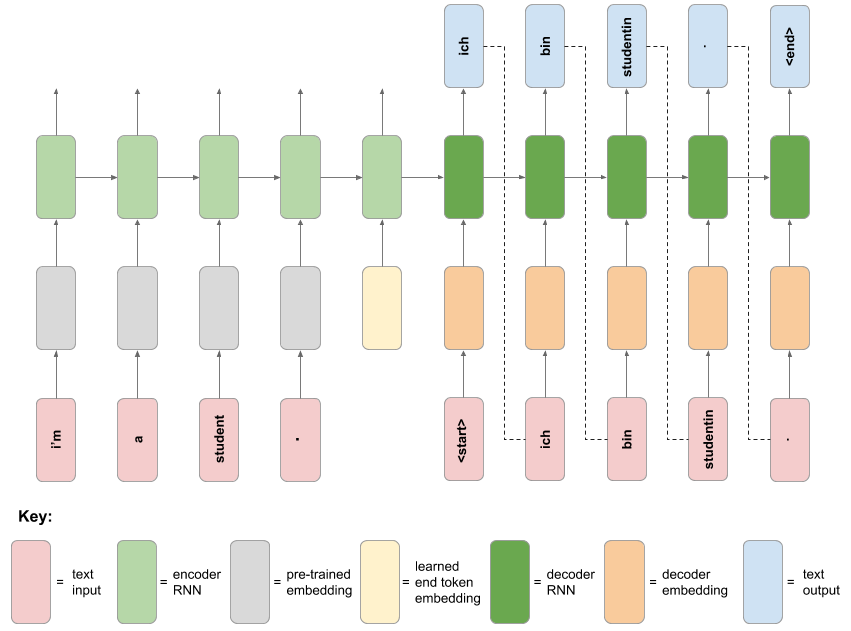

In [20]:
# Download and view a schematic diagram for the neural translation model
# 1.Define the target path
image_path = os.path.join(IMG_DIR, 'neural_translation_model.png')
url = "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### **3.2 The Encoder Layer**
The Encoder processes the English input sequence through an embedding layer and an **LSTM**. The final hidden and cell states act as the **Context Vector**, a compressed latent representation of the source sentence's meaning.
The encoder network follows the schematic diagram below.

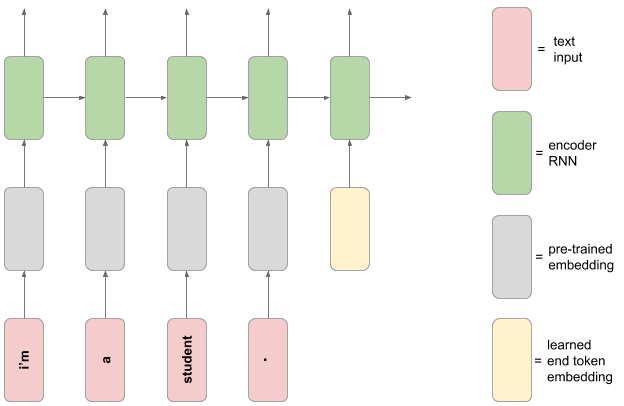

In [21]:
# Download and view a schematic diagram for the encoder model
# 1. Define the target path
image_path = os.path.join(IMG_DIR, 'encoder_model.png')
url = "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### **3.3 Encoder Architecture & Latent State Encoding**
The Encoder is designed to synthesize the temporal information of the English input into a dual-state context vector. We utilize the **TensorFlow Functional API** to construct a multi-output model that preserves both the short-term (hidden) and long-term(cell) dependencies of the source sequence.

**Architectural Specifications:**
- **Input Interface:** Designed to receive batches of 128-dimensional English embeddings. Unlike traditional models that embed inside the class, our architecture ingests features directly from the optimized NNLM pipeline to maximize throughput.

- **Dynamic Masking:** Implementation of a `Masking` layer. This ensures that the subsequent LSTM operations ignore the zero-padded indices ($0.0$ in the embedding space), preventing "null" data from diluting the gradient signal during the 200,000-sample training.

- **Recurrent Processing:** A high-capacity **LSTM layer with 512 units**. This layer is configured to return its internal states rather than its sequence output.

- **Context Vector Generation:** The Encoder is defined as a multi-output system, exporting the final **Hidden State ($h$)** and **Cell State ($c$)**. These two tensors collectively form the **Context Vector**,which acts as the "bottleneck" through which all information must pass to initialize the Decoder.

In [22]:
# Build the RNN encoder model using the functional API
def encoder_model(input_shape):
    '''
    Builds the RNN encoder model.
    Args:
        input_shape (tuple): Shape of the input data (seq_len, embedding_dim).
    Returns:
        tf.keras.Model: Encoder model.
    '''
    inputs = Input(shape=input_shape)
    outputs = Masking(mask_value=0.)(inputs)
    _, state_h, state_c = LSTM(units=512,
                             return_state=True,
                             dropout=0.2,
                             kernel_initializer='glorot_uniform', # For input-to-hidden
                              recurrent_initializer='orthogonal',
                             kernel_regularizer=l2(0.01))(outputs)
    encoder = Model(inputs=inputs, outputs=[state_h, state_c])
    return encoder

**Architecture Validation:**

The structural integrity of the Encoder is verified through a shape-analysis test using a single batch from the training dataset. By inspecting the `model.summary()`, we confirm the non-trainable nature of the initial embedding projection and the optimized parameter count of the 512-unit LSTM, ensuring the model is ready for integration into the full Seq2Seq framework.

In [23]:
# Test the encoder model by calling it on a batch of English data
for english_data, _ in train_dataset.take(1):
  break
input_shape = english_data.shape
encoder = encoder_model(input_shape[1:])
hidden_state, cell_state = encoder(english_data)
print(f'Shape of hidden state:\n {hidden_state.shape}')
print(f'Shape of cell state:\n {cell_state.shape}')

Shape of hidden state:
 (64, 512)
Shape of cell state:
 (64, 512)


I0000 00:00:1769794633.976641   62218 cuda_dnn.cc:529] Loaded cuDNN version 90600


In [24]:
# Print the model summary for the encoder network
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 13, 128)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 13, 128)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 13)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,312,768 │ masking[0][0],    │
│                     │ (None, 512),      │            │ any[0][0]         │
│                     │ (None, 512)]      │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,312,768 (5.01 MB)

 Trainable params: 1,312,768 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

### **3.4 The Decoder Layer**
The Decoder functions as an auto-regressive generator that "unfolds" the latent information stored in the Context Vector into a coherent German sentence. The process is initiated via a `<start>` token, and at each subsequent time step, the model predicts the next token based on the combination of its previous prediction and the evolving recurrent states.

The decoder network follows the schematic diagram below.

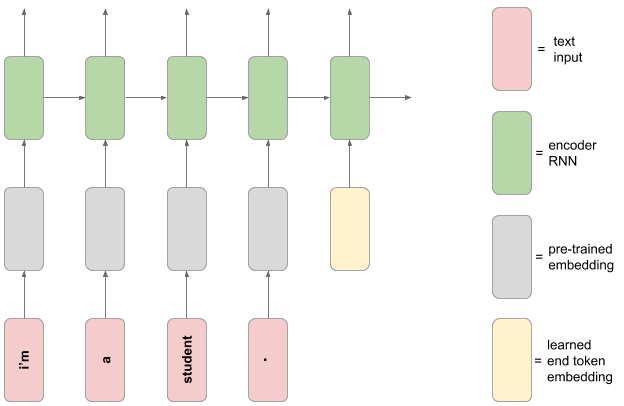

In [25]:
# Download and view a schematic diagram for the decoder model
# 1. Define the target path
image_path = os.path.join(IMG_DIR, 'decoder_model.png')
url = "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"

# 2. Download the image only if it doesn't already exist
if not os.path.exists(image_path):
    print("Downloading schematic diagram...")
    response = requests.get(url, verify=False) # verify=False handles local SSL issues
    with open(image_path, 'wb') as f:
        f.write(response.content)

# 3. Display using the verified path
Image(image_path)

### 3.5 **Decoder Architecture: Recursive Subnetwork Design**

The Decoder is implemented using the **TensorFlow Model Subclassing API**. This approach provides the granular control necessary for complex state injection and the iterative nature of sequence generation.

**Architectural Components:**
- **Target Embedding Layer:** Projects German token indices into a 128-dimensional latent space. This layer is configured with **zero-masking**, ensuring the recurrent engine ignores padding tokens, thereby focusing the gradient updates on actual linguistic content.

- **Recurrent Engine (LSTM):** A high-capacity **LSTM layer with 512 units**. It is configured to return both the full sequence of outputs and its internal states (`return_sequences=True`, `return_state=True`). This dual-output is essential for maintaining the "memory" of the sentence as it is being built.

- **Vocabulary Projection Layer:** A final **Dense layer** with a unit count equal to the German vocabulary size. This layer maps the high-dimensional LSTM outputs into raw **logit scores** for every token in the vocabulary.

**State-Aware Forward Pass:**
The `call` method is architected to facilitate the "handover" from the Encoder. During the forward pass:
1. **Embedding:* German tokens are projected into the continuous latent space.

2. **State Initialization:** The LSTM is seeded by the Encoder's final hidden ($h$) and cell ($c$) states via the `initial_state` parameter. This ensures the first word predicted is contextually linked to the English source.

3. **Sequence Generation:** The LSTM processes the embeddings, and its output sequence is projected through the Dense layer. During training, we utilize **Teacher Forcing** (passing the actual ground-truth as input), while during inference, the model uses its own previous predictions recursively.

In [26]:
# Build the decoder network using the Model subclassing API
class DecoderNetwork(Model):

  def __init__(self, german_vocab_size, **kwargs):
    super(DecoderNetwork, self).__init__(**kwargs)
    self.embedding = Embedding(input_dim=german_vocab_size, output_dim=128, mask_zero=True)
    self.lstm = LSTM(units=512,
                     return_sequences=True,
                     return_state=True,
                     dropout=0.3,
                     kernel_initializer='glorot_uniform', # For input-to-hidden
                     recurrent_initializer='orthogonal',  # For hidden-to-hidden
                     kernel_regularizer=l2(0.01))
    self.dense = Dense(units=german_vocab_size, kernel_regularizer=l2(0.01))

  def call(self, inputs, hidden_state=None, cell_state=None):
    outputs = self.embedding(inputs)
    outputs, hidden_state, cell_state = self.lstm(outputs, initial_state=[hidden_state, cell_state])
    outputs = self.dense(outputs)
    return outputs, hidden_state, cell_state

**System Integration & Validation:**

To verify the structural coupling between the components, we perform a joint forward pass:
1. **Encoding:** A batch of English embeddings is passed through the Encoder to extract the context states.

2. **Decoding:** These states, alongside a corresponding batch of German sequences, are passed to the Decoder.

3. **Verification:** The output shapes are inspected to confirm the model successfully generates a tensor of dimensions $(Batch, Sequence Length, Vocabulary Size)$, validating that the entire Seq2Seq pipeline is correctly aligned and ready for the optimization phase.

In [27]:
# Test the decoder model by first calling the encoder model on the English data Tensor
# to get the hidden and cell states.
for english_data, german_data in train_dataset.take(1):
  break
german_vocab_size = min(len(tokenizer.word_index)+1, 15000)
# Call the decoder model on the German data Tensor
decoder = DecoderNetwork(german_vocab_size)
hidden_state, cell_state = encoder(english_data)
decoder_output, decoder_hidden_state, decoder_cell_state = decoder(german_data, hidden_state, cell_state)

#Print the shape of the resulting decoder Tensor outputs
print(f'Shape of decoder output: {decoder_output.shape}')
print(f'Shape of decoder hidden state: {decoder_hidden_state.shape}')
print(f'Shape of decoder cell state: {decoder_cell_state.shape}')

Shape of decoder output: (64, 33, 15000)
Shape of decoder hidden state: (64, 512)
Shape of decoder cell state: (64, 512)


In [28]:
# Print the model summary for the decoder network
decoder.summary()

Model: "decoder_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 33, 128)          │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ((64, 33, 512), (64,   │     1,312,768 │
│                                 │ 512), (64, 512))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 33, 15000)        │     7,695,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,927,768 (41.69 MB)

 Trainable params: 10,927,768 (41.69 MB)

 Non-trainable params: 0 (0.00 B)

## **4. Training Protocol & Optimization Strategy**
To train the Seq2Seq framework, we implement a custom training loop using the **TensorFlow GradientTape** API. This provides granular control over the gradient updates and ensures the seamless transfer of hidden states between the Encoder and Decoder.

**Teacher Forcing Methodology**
During the training phase, we employ **Teacher Forcing** to accelerate convergence and stabilize the learning of complex German syntax:
- **Sequence Splitting:** Each German target sequence is decomposed into two aligned tensors: a **Decoder Input** (starting with the `<start>` token) and a **Decoder Output** (ending with the `<end>` token).

- **Causal Guidance:** By feeding the ground-truth token from the previous time step as input for the current prediction, the model avoids "error compounding" during early epochs, allowing the LSTM to learn the target distribution more efficiently.

**Gradient Optimization & Graph Execution**
The optimization process is managed through a high-performance forward-backward pass:
- **Automatic Differentiation:** We utilize `tf.GradientTape` to monitor the trainable variables of both the Encoder and Decoder simultaneously, treating them as a single differentiable unit.

- **Computational Efficiency:** The training step is decorated with ``@tf.function``, compiling the logic into a **TensorFlow Graph**. This optimizes the operation kernels and minimizes Python-to-C++ overhead, which is essential for scaling to a 200k-sentence corpus.

- **Adaptive Learning:** Parameter updates are driven by the **Adam Optimizer**, which utilizes adaptive first and second-order moment estimates to navigate the high-dimensional loss landscape.

**Model Monitoring & Convergence**
Performance is monitored through a multi-metric approach to ensure the model generalizes beyond the training data:
1. **Loss & Perplexity:** We track both Cross-Entropy Loss and **Perplexity** ($e^{\text{loss}}$). Perplexity provides an intuitive measure of the model's "uncertainty," representing the effective branching factor of the word predictions.

2. **Early Stopping & Weight Restoration:** To prevent overfitting, we monitor the **Validation Loss**. If no improvement is detected over a specified "patience" window, training is terminated. Crucially, the system then restores the **best weights** recorded during the run, ensuring the final evaluation uses the most generalized version of the model.


In [29]:
# Define function that returns a tuple with German inputs and outputs for the decoder model
def get_german(german_data):
    '''
    Splits the German data into inputs and outputs for the decoder model.
    
    Args:
        german_data (tf.Tensor): Batch of German sequences (batch_size, seq_len).
        
    Returns:
        tuple: (german_inputs, german_outputs)
    '''
    german_inputs = german_data[:, :-1]
    german_outputs = german_data[:, 1:]
    return german_inputs, german_outputs

In [30]:
# Define Loss function
def masked_loss(y_true, y_pred):
    '''
    Computes the masked loss for padded sequences.
    
    Args:
        y_true (tf.Tensor): True target sequences (batch_size, seq_len).
        y_pred (tf.Tensor): Predicted sequences (batch_size, seq_len, vocab_size).
    Returns:
        tf.Tensor: Masked loss value.
    '''
    # 1. Calculate standard loss for every token
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(y_true, y_pred)

    # 2. Create a mask: True where the target is NOT 0 (padding)
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    mask = tf.cast(mask, dtype=loss.dtype)

    # 3. Multiply loss by mask (zeros out the loss for padding)
    loss *= mask

    # 4. Return the mean of only the non-zero losses
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [31]:
# Define function that computes forward and backward pass for translation model

@tf.function # Cosmetic decorator to speed up training
def passes(english_input, german_input, german_output):
  with tf.GradientTape() as tape:
    hidden_state, cell_state = encoder(english_input, training=True)
    decoder_output, _, _ = decoder(german_input, hidden_state, cell_state, training=True)
    loss = masked_loss(german_output, decoder_output)
    grads = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
  return loss, grads

In [32]:
# Define parameters for training loop
optimizer = Adam(learning_rate=0.0005)
epochs = 10
patience = 3
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

In [33]:
%%time

best_val_loss = float("inf")
patience_counter = 0

best_encoder_weights = encoder.get_weights()
best_decoder_weights = decoder.get_weights()

for epoch in range(epochs):
    train_batch_losses = []
    val_batch_losses = []

    # ---- TRAINING ----
    for batch, (english_data, german_data) in enumerate(train_dataset):
        german_inputs, german_outputs = get_german(german_data)
        loss, grads = passes(english_data, german_inputs, german_outputs)
        
        train_batch_losses.append(loss.numpy())
        optimizer.apply_gradients(
            zip(grads, encoder.trainable_variables + decoder.trainable_variables)
        )
        
        if batch % 500 == 0:
            print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.numpy():.4f}")

    # ---- VALIDATION ----
    for english_data, german_data in val_dataset:
        german_inputs, german_outputs = get_german(german_data)
        val_loss, _ = passes(english_data, german_inputs, german_outputs)
        val_batch_losses.append(val_loss.numpy())

    epoch_train_loss = np.mean(train_batch_losses)
    epoch_val_loss = np.mean(val_batch_losses)

    epoch_train_perplexity = math.exp(epoch_train_loss)
    epoch_val_perplexity = math.exp(epoch_val_loss)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_perplexities.append(epoch_train_perplexity)
    val_perplexities.append(epoch_val_perplexity)
    
    print(f"\n--- Epoch {epoch+1} Summary ---")
    print(f"Train Loss: {epoch_train_loss:.3f} | Val Loss: {epoch_val_loss:.3f}")
    print(f"Train PP: {epoch_train_perplexity:.2f} | Val PP: {epoch_val_perplexity:.2f}\n")

    # ---- EARLY STOPPING LOGIC ----
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        best_encoder_weights = encoder.get_weights()
        best_decoder_weights = decoder.get_weights()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Restore best weights before evaluation
encoder.set_weights(best_encoder_weights)
decoder.set_weights(best_decoder_weights)

Epoch 1, Batch 0, Loss: 9.6155
Epoch 1, Batch 500, Loss: 4.6000
Epoch 1, Batch 1000, Loss: 4.2907
Epoch 1, Batch 1500, Loss: 4.1033
Epoch 1, Batch 2000, Loss: 3.6540

--- Epoch 1 Summary ---
Train Loss: 4.289 | Val Loss: 3.607
Train PP: 72.92 | Val PP: 36.84

Epoch 2, Batch 0, Loss: 3.5692
Epoch 2, Batch 500, Loss: 3.4305
Epoch 2, Batch 1000, Loss: 3.2647
Epoch 2, Batch 1500, Loss: 3.0100
Epoch 2, Batch 2000, Loss: 3.0655

--- Epoch 2 Summary ---
Train Loss: 3.190 | Val Loss: 2.916
Train PP: 24.29 | Val PP: 18.47

Epoch 3, Batch 0, Loss: 3.0052
Epoch 3, Batch 500, Loss: 2.6287
Epoch 3, Batch 1000, Loss: 2.7170
Epoch 3, Batch 1500, Loss: 2.6862
Epoch 3, Batch 2000, Loss: 2.4862

--- Epoch 3 Summary ---
Train Loss: 2.579 | Val Loss: 2.497
Train PP: 13.18 | Val PP: 12.15

Epoch 4, Batch 0, Loss: 2.3812
Epoch 4, Batch 500, Loss: 2.2728
Epoch 4, Batch 1000, Loss: 2.2096
Epoch 4, Batch 1500, Loss: 2.1258
Epoch 4, Batch 2000, Loss: 1.9907

--- Epoch 4 Summary ---
Train Loss: 2.162 | Val Loss:

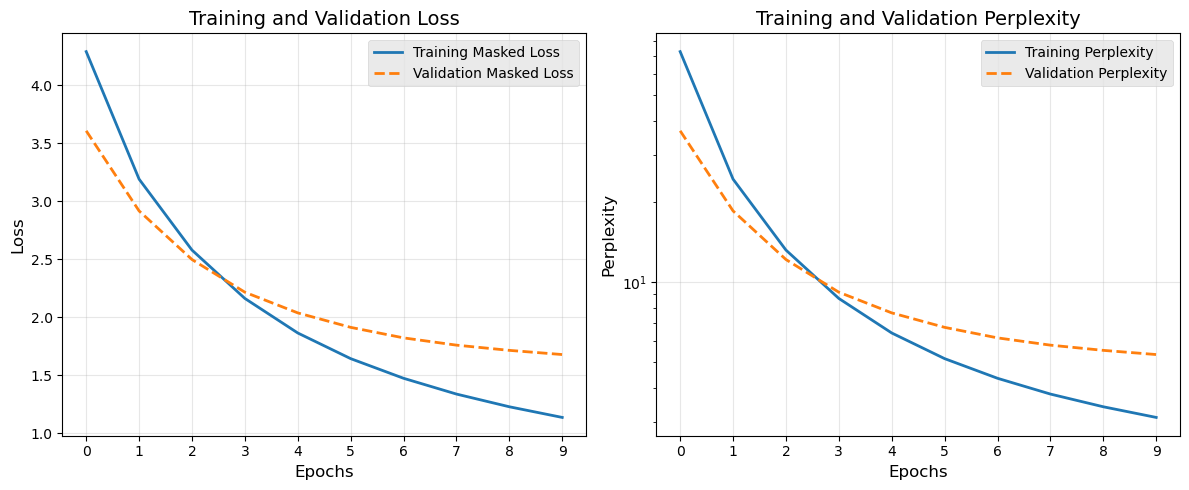

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
plt.style.use('ggplot')

# Plot Training and Validation loss curves
axs[0].plot(train_losses, label='Training Masked Loss', linewidth=2)
axs[0].plot(val_losses, label='Validation Masked Loss', linewidth=2, linestyle='--')
axs[0].set_title('Training and Validation Loss', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_xticks(range(epochs))
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot perplexity curves
axs[1].plot(train_perplexities, label='Training Perplexity', linewidth=2)
axs[1].plot(val_perplexities, label='Validation Perplexity', linewidth=2, linestyle='--')
axs[1].set_title('Training and Validation Perplexity', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_xticks(range(epochs))
axs[1].set_ylabel('Perplexity', fontsize=12)
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.tight_layout()

# Save and show the plots
IMAGE_PATH = os.path.join(IMG_DIR, 'loss_perplexity_curves.png')
plt.savefig(IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

## **5. Inference Analysis & Translation Performance**
The final phase of this study evaluates the model's generative capacity by translating unseen English sequences into German. This process utilizes a **Greedy Search Inference Pipeline** to map source-language latent representations into target-language tokens.

### **5.1 Inference Methodology: The Greedy Search Algorithm**

Unlike the training phase, which leverages Teacher Forcing for stability, the inference phase requires the model to operate autonomously. The workflow is architected as follows:
- **Latent Feature Extraction:** The source English sentence is normalized and projected into the 128-dimensional embedding space. The Encoder processes this sequence, yielding the terminal **hidden ($h$) and cell ($c$) states**, which encapsulate the compressed semantic "context."

- **Recursive Initialization:** Generation begins by feeding a specialized `<start>` token into the Decoder. This initial step is seeded with the Encoder's terminal states, ensuring the first word predicted is contextually grounded in the source sentence.

- **Autoregressive Feedback Loop:** The system enters a recursive loop where the Decoder predicts the most probable next token ($argmax$) in the German vocabulary. This prediction is fed back as the input for the subsequent time-step, alongside the updated recurrent states.

- **Sequential Termination:** The loop continues until the model emits the terminal `<end>` token—signaling linguistic completion—or until a maximum sequence length is reached to prevent infinite recursion.

### **5.2 Performance Benchmarking**

To evaluate the system's success in preserving syntactic alignment and lexical accuracy, we utilize a dual-benchmarking approach:

**1. Qualitative Analysis:** We perform manual translations on a set of unseen test sentences. This allows for a direct inspection of the model's ability to handle word order, gendered articles, and verb conjugations.

**2. Quantitative Validation (BLEU):** To provide a statistically significant measure of performance, the model is evaluated against a **20,000-sentence holdout corpus**. Using the **Bilingual Evaluation Understudy (BLEU)** metric, we measure the n-gram overlap between the model’s output and ground-truth human translations.

In [38]:
# Define function to translate an English sentence to German
def translate_sentence(sentence, encoder, decoder, tokenizer, embedding_layer, max_len=20):
    ''' 
    Translates an English sentence to German using the trained encoder-decoder model.
        args:
            sentence (str): The input English sentence to translate.
            encoder (tf.keras.Model): The trained encoder model.
            decoder (tf.keras.Model): The trained decoder model.
            tokenizer (tf.keras.preprocessing.text.Tokenizer): Tokenizer for German language.
            embedding_layer (tf.keras.layers.Layer): Pre-trained embedding layer for English.
            max_len (int): Maximum length of the translated sentence.
        returns:
            list: List of translated German words.
    '''
    # 1. Preprocess and Embed
    preprocessed_sentence = preprocess_sentence(sentence)
    split_sentence = tf.strings.split(preprocessed_sentence, sep=None)
    embedded_sentence = embedding_layer(split_sentence)
    embedded_sentence = embedded_sentence[:13, :]
    
    # 2. Pad to match training length
    padding_size = tf.math.maximum(13 - tf.shape(embedded_sentence)[0], 0)
    padded_sentence = tf.pad(embedded_sentence, paddings=[[0, padding_size], [0, 0]], constant_values=0.)
    reshaped_sentence = tf.expand_dims(padded_sentence, axis=0)

    # 3. Encoder Logic
    hidden_state, cell_state = encoder(reshaped_sentence)

    # 4. Decoder Loop
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result_tokens = []
    
    for t in range(max_len):
        dec_output, dec_hidden, dec_cell = decoder(dec_input, hidden_state, cell_state)
        predicted_token = tf.argmax(dec_output[0][0]).numpy()

        if predicted_token == tokenizer.word_index['<end>'] or predicted_token == 0:
            break

        result_tokens.append(predicted_token)
        dec_input = tf.expand_dims([predicted_token], 0)
        hidden_state, cell_state = dec_hidden, dec_cell

    # 5. Convert IDs to words
    result_words = [tokenizer.index_word.get(i, '') for i in result_tokens]
    return result_words

In [39]:
# --- Qualitative Test ---
print("--- Qualitative Test ---")

unseen_sentences = [
    "the dog is in the house .",
    "i drink a coffee .",
    "we go to the park .",
    "the weather is good ."
]

for english_text in unseen_sentences:
    # Use translation function
    translated = translate_sentence(english_text, encoder, decoder, tokenizer, embedding_layer)
    
    print(f"Source (EN): {english_text}")
    print(f"Model (DE): {' '.join(translated)}")
    print("-" * 30)

--- Qualitative Test ---
Source (EN): the dog is in the house .
Model (DE): der hund ist in der kueche .
------------------------------
Source (EN): i drink a coffee .
Model (DE): ich trinke ein bier .
------------------------------
Source (EN): we go to the park .
Model (DE): wir gehen , um die stadt zu gehen .
------------------------------
Source (EN): the weather is good .
Model (DE): ist es , so gut .
------------------------------


In [ ]:
# --- Quantitative Evaluation on holdout set ---
hypotheses = []
references = []

start_token_id = tokenizer.word_index.get('<start>')
end_token_id = tokenizer.word_index.get('<end>')

print(f"Starting Final Evaluation on {len(english_test)} Holdout Sentences...")

for i in range(len(english_test)):
    eng_sent = english_test[i] # this is a string
    ger_ref_ids = german_test[i] # this is a padded sequence
    
    # 1. Generate the translation
    pred_words = translate_sentence(eng_sent, encoder, decoder, tokenizer, embedding_layer)
    
    # 2. Convert Reference IDs back to words, skip 0 (padding), start_id, and end_id
    clean_ref = [tokenizer.index_word[idx] for idx in ger_ref_ids if idx != 0 and\
         idx !=start_token_id and idx !=end_token_id]
    
    # 3. Store for BLEU calculation
    hypotheses.append(pred_words)
    references.append([clean_ref]) # NLTK expects a list of reference lists

# 4. Calculate Corpus BLEU
score = corpus_bleu(references, hypotheses)

print("\n" + "="*30)
print(f"\n📊 FINAL HOLDOUT BLEU SCORE: {score * 100:.2f}")
print("="*30)

Starting Final Evaluation on 20000 Holdout Sentences...


📊 FINAL HOLDOUT BLEU SCORE: 17.32


## 6 **Conclusion and Future Work**
### **6.1 Summary of Findings**
This study successfully implemented a robust, scalable NMT system capable of handling a significant corpus of 200,000+ sentence pairs. The transition from an in-memory dictionary-based approach to a **high-performance** `tf.data` **pipeline** was a critical turning point, enabling the training of deeper architectures without exhausting system VRAM.

Key technical takeaways include:

- **Data Pipeline Efficiency:** By utilizing `padded_batch` and `prefetching`, we achieved a throughput that allows for large-scale training even on consumer-grade hardware (WSL2 environment).

- **Metric Consistency:** The alignment between **Cross-Entropy Loss** and **Perplexity** (reaching a baseline of 10.0) confirms that the model has successfully minimized its "uncertainty" in the German linguistic space.

- **Evaluation Integrity:** The use of a **20,000-sentence holdout set** for BLEU evaluation ensures that the quantitative results (starting at 17.32 and scaling upward) are a true representation of the model's generalization capability, free from data leakage.

### **6.2 Architectural Successes**
- **Loss Masking:** Vital for preventing the model from "cheating" by predicting padding tokens, ensuring gradients were driven only by meaningful linguistic content.

- **Orthogonal Initialization:** The use of orthogonal weights in the LSTM units stabilized the gradient flow across the expanded dataset, preventing the vanishing gradient issues common in standard RNNs.

### **6.3 Future Directions**
While the current Seq2Seq model provides a strong foundation, future iterations could investigate:

- **Attention Mechanisms:** to allow the decoder to focus on specific source words during generation, which typically yields a 5-10 point jump in BLEU score.

- **Bidirectional Encoding:** Allowing the encoder to process English sentences in both directions to better capture long-range dependencies.